In [1]:
import json as json
import pathlib as pl
from copy import deepcopy
from datetime import datetime
from gc import collect
from os import path, system
from warnings import simplefilter

import matplotlib.pyplot as plt
from matplotlib import rcParams
from numpy import array, linspace, meshgrid, ones, zeros
from numpy.linalg import norm
from scipy.spatial.transform import Rotation
from tqdm import tqdm

from catenary import Catenary
from seafloor import SeafloorFromFunction
from utils import check, compare_dict, gif_from_pngs, print_dict

simplefilter( 'ignore', RuntimeWarning )

gain = 1.5
rcParams[ 'figure.figsize' ] = [ gain * 6.4, gain * 4.8 / 2 ]
# rcParams['figure.facecolor'] = 'black'
# rcParams['axes.edgecolor'] = 'white'
# rcParams['axes.facecolor'] = 'black'
# rcParams['axes.labelcolor'] = 'white'
# rcParams['xtick.color'] = 'white'
# rcParams['ytick.color'] = 'white'
# rcParams['legend.labelcolor'] = 'white'
# rcParams['legend.facecolor'] = 'black'

In [2]:
files = list( pl.Path( "./export" ).glob( '*' ) )
files.sort( key = lambda x: path.getctime( x ) )
for v in files:
	print( str( v ).split( '//' )[ -1 ], end = '\t' )
	print( datetime.fromtimestamp( path.getctime( v ) ) )

export\three_robots_chain_1726157070	2024-09-17 09:04:31.536003
export\Figure_1.png	2024-10-10 09:58:20.942149
export\three_robots_chain_with_fixed_end_1726429003	2024-10-24 16:48:58.855255
export\three_robots_chain_1726514783	2024-10-24 19:05:24.019054
export\three_robots_chain_with_fixed_end_1726554218	2024-10-24 19:05:24.068337
export\chain_of_four_1730371997	2024-10-31 11:53:17.502967
export\chain_of_four_1730384599	2024-10-31 15:23:19.554600
export\chain_of_four_1731930190	2024-11-18 12:43:10.902510
export\chain_of_four_1732006722	2024-11-19 09:58:42.559082
export\mpc_simulation_1732024220	2024-11-19 14:50:20.596047


In [3]:
compare_folder_0 = pl.Path( './export/mpc_simulation_1732024220' )
compare_folder_1 = pl.Path( './export/chain_of_four_1732006722' )
with open( compare_folder_0 / 'config.json' ) as f0:
	with open( compare_folder_1 / 'config.json' ) as f1:
		compare_config_0 = json.load( f0 )
		compare_config_1 = json.load( f1 )
		print( '\t', compare_folder_0, '\t', compare_folder_1, flush = True )
		compare_dict( compare_config_0, compare_config_1, only_diff = True )

	 export\mpc_simulation_1732024220 	 export\chain_of_four_1732006722
save_rate <class 'int'> : 5 0
target_trajectory <class 'list'> : 1000 400
model <class 'dict'> :
	dynamics <class 'dict'> :
		br_1 <class 'dict'> :
			build_transformation_matrix <class 'str'> : 	@staticme 	@staticme
		br_0 <class 'dict'> :
			build_transformation_matrix <class 'str'> : 	@staticme 	@staticme
		sf <class 'dict'> :
			seafloor_function <class 'str'> : def seaflo def seaflo
		br_2 <class 'dict'> :
			build_transformation_matrix <class 'str'> : 	@staticme 	@staticme


In [4]:
print( compare_config_0[ 'model' ][ 'dynamics' ][ 'br_0' ][ 'build_transformation_matrix' ] )

	@staticmethod
	def build_transformation_matrix( phi: float, theta: float, psi: float ) -> ndarray:
		cPsi, sPsi = cos( psi ), sin( psi )

		matrix = eye( 6 )
		matrix[ 0, 0 ] = cPsi
		matrix[ 0, 1 ] = -sPsi
		matrix[ 1, 0 ] = sPsi
		matrix[ 1, 1 ] = cPsi

		return matrix



In [5]:
folder = pl.Path( './export/mpc_simulation_1732024220' )
uuid = str( folder ).split( '_' )[ -1 ]
with open( folder / 'config.json' ) as f:
	config = json.load( f )
print_dict( config )

predict <class 'str'> : 	def _pred ...
get_actuation <class 'str'> : 	def _get_ ...
get_result <class 'str'> : 	def _get_ ...
model <class 'dict'> :
	dynamics <class 'dict'> :
		br_0 <class 'dict'> :
			state_size <class 'int'> : 12
			pose_size <class 'int'> : 6
			actuation_size <class 'int'> : 4
			linear_actuation_size <class 'int'> : 3
			build_transformation_matrix <class 'str'> : 	@staticme ...
			build_inertial_matrix <class 'str'> : 	@staticme ...
			mass <class 'float'> : 11.5
			center_of_mass <class 'list'> : [0.0, 0.0, 0.0]
			weight <class 'list'> : [0.0, 0.0, 112.77647499999999]
			volume <class 'float'> : 0.0134
			center_of_volume <class 'list'> : [0.0, 0.0, -0.01]
			buoyancy <class 'list'> : [-0.0, -0.0, -131.01488267000002]
			water_surface_depth <class 'float'> : 0.0
			water_current <class 'list'> : [0.5, 0.5, 0.0, 0.0, 0.0, 0.0]
			inertial_coefficients <class 'list'> : [0.26, 0.23, 0.37, 0.0, 0.0, 0.0]
			hydrodynamic_coefficients <class 'list'> : [13.7, 0.0, 33

In [6]:
slice_repository = { }
axes = [ 'x', 'y', 'z', 'phi', 'theta', 'psi', 'u', 'v', 'w', 'p', 'q', 'r' ]

for k, v in config[ 'model' ][ 'dynamics' ].items():
	if isinstance( v, str ) and '\n' not in v and ':' in v:
		slice_repository[ k ] = slice( *[ int( v ) if v != 'None' else None for v in v.split( ':' ) ] )
	elif isinstance( v, int ) and 'br_' in k:
		slice_repository[ k ] = v

pose = { k: v for k, v in slice_repository.items() if 'pose' in k }
positions = { k: v for k, v in slice_repository.items() if 'position' in k }
orientations = { k: v for k, v in slice_repository.items() if 'orientation' in k }
positions_pairs = { '_'.join( a.split( '_' )[ :2 ] ): '_'.join( b.split( '_' )[ :2 ] ) for a, b in
										zip( list( positions )[ :-1 ], list( positions )[ 1: ] ) }
speeds = { k: v for k, v in slice_repository.items() if 'linear_speed' in k }
linear_actuation = { k: v for k, v in slice_repository.items() if 'linear_actuation' in k }
angular_actuation = { k: v for k, v in slice_repository.items() if 'angular_actuation' in k }

times = [ config[ 'model' ][ 'time_step' ] * i for i in range( len( config[ 'target_trajectory' ] ) ) ]

target_trajectory = array( config[ 'target_trajectory' ] )[ :, 0 ]

pose_weight = array( config[ 'pose_weight_matrix' ][ 0 ] )

save_rate = config.get( 'save_rate', 1 )

seafloor_config = config[ 'model' ][ 'dynamics' ][ 'sf' ]
if seafloor_config[ 'instance_of' ] == 'SeafloorFromFunction':
	exec( seafloor_config[ 'seafloor_function' ] )
	seafloor = SeafloorFromFunction(
			globals()[ seafloor_config[ 'seafloor_function' ].split( '\n' )[ 0 ][ 4: ].split( '(' )[ 0 ] ]
			)
else:
	raise NotImplementedError

In [7]:
for i, c in enumerate( config[ 'constraints' ] ):
	c = c.get( 'constraint', c )
	for j, (lb, ub, label, vlabel) in enumerate( zip( c[ 'lb' ], c[ 'ub' ], c[ 'labels' ], c[ 'value_labels' ] ) ):
		print( f'{(i + 1) * j}.\t{label}: {lb}\t<=\t{vlabel}\t<=\t{ub}' )

0.	seafloor: 0.2	<=	c_01_distance_to_seafloor	<=	inf
1.	seafloor: 0.2	<=	c_12_distance_to_seafloor	<=	inf
2.	seafloor: 0.2	<=	c_23_distance_to_seafloor	<=	inf
3.	seafloor: 0.2	<=	br_0_distance_to_seafloor	<=	inf
4.	seafloor: 0.2	<=	br_1_distance_to_seafloor	<=	inf
5.	seafloor: 0.2	<=	br_2_distance_to_seafloor	<=	inf
6.	seafloor: 0.2	<=	br_3_distance_to_seafloor	<=	inf
7.	cable_length: 0.2	<=	br_0_br_1_horizontal_distance	<=	2.8
8.	cable_length: 0.2	<=	br_1_br_2_horizontal_distance	<=	2.8
9.	cable_length: 0.2	<=	br_2_br_3_horizontal_distance	<=	2.8
10.	cable_length: -inf	<=	br_0_br_1_distance	<=	2.8
11.	cable_length: -inf	<=	br_1_br_2_distance	<=	2.8
12.	cable_length: -inf	<=	br_2_br_3_distance	<=	2.8


In [8]:
data_files = list( folder.glob( 'data/*' ) )
data_files.sort( key = lambda x: path.getmtime( x ) )
n_frames = len( data_files ) * save_rate
back_offset = 1 * save_rate if n_frames != target_trajectory.shape[ 0 ] else 0

with open( data_files[ -2 ] ) as f:
	final_state = json.load( f )

previous_times = [ config[ 'model' ][ 'time_step' ] * i for i in range( n_frames - back_offset ) ]
previous_target_trajectory = target_trajectory[ :n_frames - back_offset ]
previous_actual_trajectory = array( final_state[ 'model' ][ 'previous_states' ] )[ 1:,
														 :config[ 'model' ][ 'dynamics' ][ 'state_size' ] ]
previous_actuations = array( final_state[ 'model' ][ 'previous_actuations' ] )

In [9]:
check( f'{folder}/plots' )

24

In [10]:
for k, v in positions.items():
	if norm( pose_weight[ v, v ] ) == 0:
		continue
	absolute_distances = abs( previous_target_trajectory[ :, v ] - previous_actual_trajectory[ :, v ] )
	plt.plot( previous_times, absolute_distances )
	plt.legend(
			[
					r'over $\mathbf{x}_w$-axis',
					r'over $\mathbf{y}_w$-axis',
					r'over $\mathbf{z}_w$-axis'
					]
			)
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'absolute error [m]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_tracking_error_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [11]:
for k, v in orientations.items():
	if norm( pose_weight[ v, v ] ) == 0:
		continue
	plt.plot( previous_times, abs( previous_target_trajectory[ :, v ] - previous_actual_trajectory[ :, v ] ) )
	plt.legend(
			[
					r'around $\mathbf{x}_w$-axis',
					r'around $\mathbf{y}_w$-axis',
					r'around $\mathbf{z}_w$-axis'
					]
			)
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'absolute error [rad]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_tracking_error_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [12]:
for k, v in linear_actuation.items():
	plt.plot( previous_times, previous_actuations[ :-1, v ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'actuation [N]' )
	plt.legend(
			[
					r'over $\mathbf{x}_r$-axis',
					r'over $\mathbf{y}_r$-axis',
					r'over $\mathbf{z}_r$-axis'
					]
			)
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [13]:
for k, v in angular_actuation.items():
	plt.plot( previous_times, previous_actuations[ :-1, v ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'actuation [Nm]' )
	plt.legend(
			[
					r'around $\mathbf{x}_r$-axis',
					r'around $\mathbf{y}_r$-axis',
					r'around $\mathbf{z}_r$-axis'
					]
			)
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [14]:
legends = [ ]
for pair_1, pair_2 in positions_pairs.items():
	position_1 = deepcopy( previous_actual_trajectory[ :, slice_repository[ pair_1 + '_position' ] ] )
	position_2 = deepcopy( previous_actual_trajectory[ :, slice_repository[ pair_2 + '_position' ] ] )

	lowest_points = zeros( (position_1.shape[ 0 ],) )
	seafloor_points = zeros( (position_1.shape[ 0 ],) )

	name = f'c_{pair_1.split( "_" )[ -1 ]}{pair_2.split( "_" )[ -1 ]}'
	cat = Catenary(
			config[ 'model' ][ 'dynamics' ][ name ][ 'length' ],
			config[ 'model' ][ 'dynamics' ][ name ][ 'linear_mass' ]
			)

	for i, (p1, p2) in enumerate( zip( position_1, position_2 ) ):
		lp = cat.get_lowest_point( p1, p2 )
		lowest_points[ i ] = lp[ 2 ]
		seafloor_points[ i ] = seafloor.get_seafloor_depth( lp )

	plt.plot( previous_times, lowest_points )
	plt.plot( previous_times, seafloor_points, ':' )
	legends += [ name, f'seafloor beneath {name}' ]

plt.legend( legends )
plt.xlabel( 'time [s]' )
plt.ylabel( 'distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.gca().invert_yaxis()
plt.savefig( f'{folder}/plots/lowest_points_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [15]:
for pair_1, pair_2 in positions_pairs.items():
	absolute_distances = norm(
			previous_actual_trajectory[ :, positions[ pair_1 + '_position' ] ] -
			previous_actual_trajectory[ :, positions[ pair_2 + '_position' ] ],
			axis = 1
			)
	plt.plot( previous_times, absolute_distances )
plt.legend( [ f'from {a} to {b}' for a, b in positions_pairs.items() ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/plots/distance_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [16]:
for p1, p2 in positions_pairs.items():
	absolute_distances = norm(
			previous_actual_trajectory[ :, slice_repository[ p1 + '_xy' ] ] -
			previous_actual_trajectory[ :, slice_repository[ p2 + '_xy' ] ],
			axis = 1
			)
	plt.plot( previous_times, absolute_distances )
plt.legend( [ f'from {a} to {b}' for a, b in positions_pairs.items() ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/plots/horizontal_distance_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [17]:
figs = [ 'x', 'y', 'z' ]

x = plt.figure().subplots()
y = plt.figure().subplots()
z = plt.figure().subplots()
z.invert_yaxis()

legends = [ [ ], [ ], [ ] ]

for k, v in positions.items():
	position = previous_actual_trajectory[ :, v ]

	X = position[ :, 0 ]
	Y = position[ :, 1 ]
	Z = position[ :, 2 ]

	x.plot( previous_times, X )
	y.plot( previous_times, Y )
	z.plot( previous_times, Z )

	for i in range( 3 ):
		legends[ i ] += [ f'{k}' ]

	if norm( pose_weight[ v, v ][ :, 0 ] ) > 0:
		target = previous_target_trajectory[ :, v ][ :, 0 ]
		x.plot( previous_times, target, ':', linewidth = 3 )
		legends[ 0 ] += [ f'{k} target' ]

	if norm( pose_weight[ v, v ][ :, 1 ] ) > 0:
		target = previous_target_trajectory[ :, v ][ :, 1 ]
		y.plot( previous_times, target, ':', linewidth = 3 )
		legends[ 1 ] += [ f'{k} target' ]

	if norm( pose_weight[ v, v ][ :, 2 ] ) > 0:
		target = previous_target_trajectory[ :, v ][ :, 2 ]
		z.plot( previous_times, target, ':', linewidth = 3 )
		legends[ 2 ] += [ f'{k} target' ]

for f in plt.get_fignums():
	fig = plt.figure( f )
	plt.legend( legends[ f - 1 ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( f'position on $\\mathbf{{{figs[ f - 1 ]}}}_w$-axis [m]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/positions_on_{figs[ f - 1 ]}_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [18]:
figs = [ 'x', 'y', 'z' ]

x = plt.figure().subplots()
y = plt.figure().subplots()
z = plt.figure().subplots()
z.invert_yaxis()

legends = [ [ ], [ ], [ ] ]

for k, v in speeds.items():
	speed = previous_actual_trajectory[ :, v ]

	X = speed[ :, 0 ]
	Y = speed[ :, 1 ]
	Z = speed[ :, 2 ]

	x.plot( previous_times, X )
	y.plot( previous_times, Y )
	z.plot( previous_times, Z )

	for i in range( 3 ):
		legends[ i ] += [ f'{k}' ]

for f in plt.get_fignums():
	fig = plt.figure( f )
	plt.legend( legends[ f - 1 ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( f'speed on $\\mathbf{{{figs[ f - 1 ]}}}_r$-axis [m/s]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/speeds_on_{figs[ f - 1 ]}_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [19]:
plt.plot( previous_times, final_state[ 'compute_times' ] )
plt.hlines(
		config[ 'time_step' ] * config[ 'horizon' ] * config[ 'time_step_prediction_factor' ],
		0,
		previous_times[ -1 ],
		'r',
		'--'
		)
plt.legend( [ 'compute time', 'horizon depth' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'time [s]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/plots/compute_times_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [20]:
frames_already_done = check( f'{folder}/plots/3d_frames' )

  0%|          | 0/5 [00:01<?, ?it/s]


IndexError: index 495 is out of bounds for axis 0 with size 495

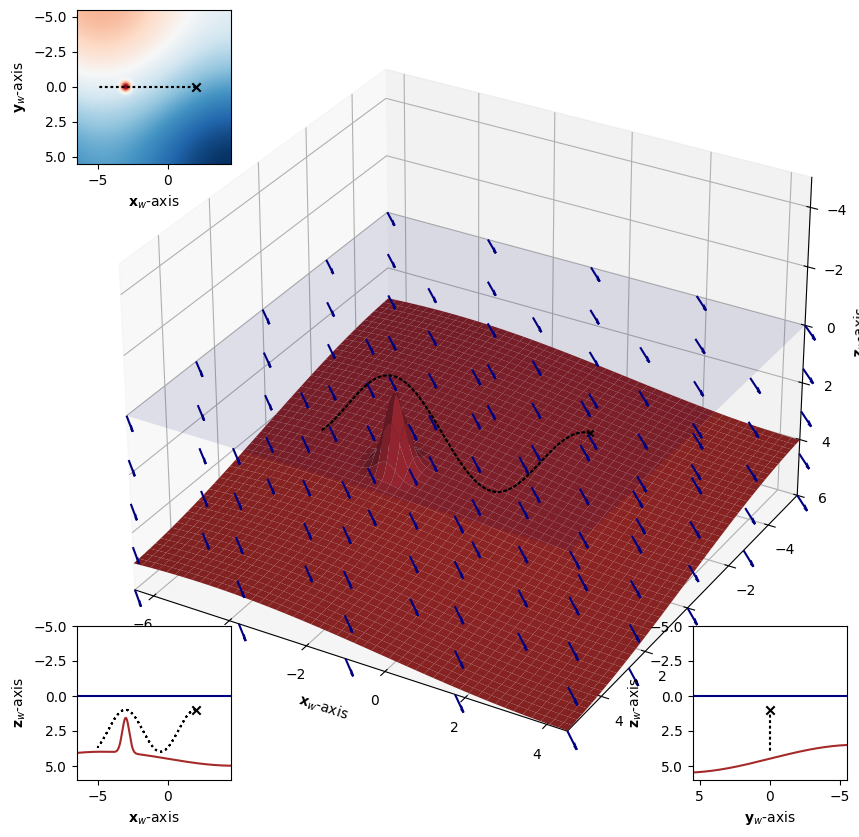

In [21]:
robots_colors = { '0': 'r', '1': 'g', '2': 'b', '3': 'y', '4': 'm' }
quiver_scale = .5
box = [ [ -6.5, 4.5 ], [ -5.5, 5.5 ], [ -5, 6 ] ]

water_current = config[ 'model' ][ 'dynamics' ][ 'br_0' ][ 'water_current' ]
water_surface = config[ 'model' ][ 'dynamics' ][ 'br_0' ][ 'water_surface_depth' ]

Xc = linspace( box[ 0 ][ 0 ], box[ 0 ][ 1 ], 5 )
Yc = linspace( box[ 1 ][ 0 ], box[ 1 ][ 1 ], 5 )
Zc = linspace(
		box[ 2 ][ 0 ] if box[ 2 ][ 0 ] > water_surface else water_surface,
		box[ 2 ][ 1 ],
		5
		)

Xc, Yc, Zc = meshgrid( Xc, Yc, Zc )

Uc = water_current[ 0 ] * ones( Xc.shape )
Vc = water_current[ 1 ] * ones( Xc.shape )
Wc = water_current[ 2 ] * ones( Xc.shape )

Xs = linspace( box[ 0 ][ 0 ], box[ 0 ][ 1 ], 1000 )
Ys = linspace( box[ 1 ][ 0 ], box[ 1 ][ 1 ], 1000 )
Xg, Yg = meshgrid( Xs, Ys )
Zws = water_surface * ones( Xg.shape )
Zsf = zeros( Xg.shape )
Zsfx = zeros( Xs.shape )
Zsfy = zeros( Ys.shape )

for i, y in enumerate( Ys ):
	Zsfy[ i ] = seafloor.get_seafloor_depth( array( [ 0, y, 0 ] ) )
	for j, x in enumerate( Xs ):
		Zsf[ i, j ] = seafloor.get_seafloor_depth( array( [ x, y, 0 ] ) )
		if i == 0:
			Zsfx[ j ] = seafloor.get_seafloor_depth( array( [ x, 0, 0 ] ) )

for frame in tqdm( range( frames_already_done, n_frames ) ):
	if frame - frames_already_done >= 50:
		raise MemoryError( 'Memory is about to be filled, erroring out to avoid computer crash' )
	with open( data_files[ int( frame / save_rate ) ] ) as f:
		simulation_state = json.load( f )
	predicted_trajectories = array( simulation_state[ 'predicted_trajectories' ] )
	if predicted_trajectories.shape[ 0 ] > 100:
		predicted_trajectories = predicted_trajectories[ ::predicted_trajectories.shape[ 0 ] // 100 ]

	fig = plt.figure( figsize = (10, 10) )
	view = plt.subplot( projection = '3d', computed_zorder = False )
	view.set_xlabel( r"$\mathbf{x}_w$-axis" )
	view.set_ylabel( r"$\mathbf{y}_w$-axis" )
	view.set_zlabel( r"$\mathbf{z}_w$-axis" )
	view.set_xlim( *box[ 0 ] )
	view.set_ylim( *box[ 1 ] )
	view.set_zlim( *box[ 2 ] )
	view.invert_yaxis()
	view.invert_zaxis()

	inset_view_xz = view.inset_axes( [ .0, .0, .2, .2 ] )
	inset_view_xz.set_xlabel( r"$\mathbf{x}_w$-axis" )
	inset_view_xz.set_ylabel( r"$\mathbf{z}_w$-axis" )
	inset_view_xz.set_xlim( *box[ 0 ] )
	inset_view_xz.set_ylim( *box[ 2 ] )
	inset_view_xz.invert_yaxis()

	inset_view_yz = view.inset_axes( [ .8, .0, .2, .2 ] )
	inset_view_yz.set_xlabel( r"$\mathbf{y}_w$-axis" )
	inset_view_yz.set_ylabel( r"$\mathbf{z}_w$-axis" )
	inset_view_yz.set_xlim( *box[ 1 ] )
	inset_view_yz.set_ylim( *box[ 2 ] )
	inset_view_yz.invert_yaxis()
	inset_view_yz.invert_xaxis()

	inset_view_xy = view.inset_axes( [ .0, .8, .2, .2 ] )
	inset_view_xy.set_xlabel( r"$\mathbf{x}_w$-axis" )
	inset_view_xy.set_ylabel( r"$\mathbf{y}_w$-axis" )
	inset_view_xy.set_xlim( *box[ 0 ] )
	inset_view_xy.set_ylim( *box[ 1 ] )
	inset_view_xy.invert_yaxis()

	view.quiver( Xc, Yc, Zc, Uc, Vc, Wc, color = 'navy' )
	view.plot_surface( Xg, Yg, Zsf, color = 'brown', zorder = 0. )
	view.plot_surface( Xg, Yg, Zws, color = 'navy', alpha = 0.1 )

	inset_view_xy.pcolormesh( Xg, Yg, Zsf, cmap = 'RdBu' )
	inset_view_xz.plot( Xs, Zsfx, color = 'brown', zorder = 0. )
	inset_view_yz.plot( Ys, Zsfy, color = 'brown', zorder = 0. )
	inset_view_xz.axhline( water_surface, color = 'navy' )
	inset_view_yz.axhline( water_surface, color = 'navy' )

	for k, v in pose.items():

		color = robots_colors[ k.split( '_' )[ 1 ] ]

		if norm( pose_weight[ v, v ][ :3, :3 ] ) > 0:
			Xt = target_trajectory[ :, v ][ :, 0 ]
			Yt = target_trajectory[ :, v ][ :, 1 ]
			Zt = target_trajectory[ :, v ][ :, 2 ]

			view.plot( Xt, Yt, Zt, ':', color = 'k' )
			view.scatter( Xt[ frame + 1 ], Yt[ frame + 1 ], Zt[ frame + 1 ], marker = 'x', color = 'k' )
			inset_view_xz.plot( Xt, Zt, ':', color = 'k' )
			inset_view_xz.scatter( Xt[ frame + 1 ], Zt[ frame + 1 ], marker = 'x', color = 'k' )
			inset_view_yz.plot( Yt, Zt, ':', color = 'k' )
			inset_view_yz.scatter( Yt[ frame + 1 ], Zt[ frame + 1 ], marker = 'x', color = 'k' )
			inset_view_xy.plot( Xt, Yt, ':', color = 'k' )
			inset_view_xy.scatter( Xt[ frame + 1 ], Yt[ frame + 1 ], marker = 'x', color = 'k' )

		X = previous_actual_trajectory[ frame, v ][ 0 ]
		Y = previous_actual_trajectory[ frame, v ][ 1 ]
		Z = previous_actual_trajectory[ frame, v ][ 2 ]

		P = previous_actual_trajectory[ frame, v ][ :3 ]
		A = previous_actual_trajectory[ frame, v ][ 3:6 ]
		R = Rotation.from_euler( 'xyz', A ).as_matrix()

		view.quiver( *P, *(R @ array( [ quiver_scale, 0., 0. ] )), color = 'r' )
		view.quiver( *P, *(R @ array( [ 0., quiver_scale, 0. ] )), color = 'g' )
		view.quiver( *P, *(R @ array( [ 0., 0., quiver_scale ] )), color = 'b' )

		view.scatter( X, Y, Z, color = color )
		inset_view_xz.scatter( X, Z, color = color )
		inset_view_yz.scatter( Y, Z, color = color )
		inset_view_xy.scatter( X, Y, color = color )

		for trajectory in predicted_trajectories:
			X = trajectory[ :, 0, v ][ :, 0 ]
			Y = trajectory[ :, 0, v ][ :, 1 ]
			Z = trajectory[ :, 0, v ][ :, 2 ]

			view.plot( X, Y, Z, linewidth = .5, color = color )
			inset_view_xz.plot( X, Z, linewidth = .5, color = color )
			inset_view_yz.plot( Y, Z, linewidth = .5, color = color )
			inset_view_xy.plot( X, Y, linewidth = .5, color = color )

	for p1, p2 in positions_pairs.items():

		color = robots_colors[ p1.split( '_' )[ 1 ] ]

		position_1 = deepcopy( previous_actual_trajectory[ frame, positions[ p1 + '_position' ] ] )
		position_2 = deepcopy( previous_actual_trajectory[ frame, positions[ p2 + '_position' ] ] )

		name = f'c_{p1.split( "_" )[ -1 ]}{p2.split( "_" )[ -1 ]}'
		cat = Catenary(
				config[ 'model' ][ 'dynamics' ][ name ][ 'length' ],
				config[ 'model' ][ 'dynamics' ][ name ][ 'linear_mass' ]
				)

		cat_12 = cat.discretize( position_1, position_2 )

		view.plot( cat_12[ :, 0 ], cat_12[ :, 1 ], cat_12[ :, 2 ], color = color )
		inset_view_xz.plot( cat_12[ :, 0 ], cat_12[ :, 2 ], color = color )
		inset_view_yz.plot( cat_12[ :, 1 ], cat_12[ :, 2 ], color = color )
		inset_view_xy.plot( cat_12[ :, 0 ], cat_12[ :, 1 ], color = color )

	plt.savefig( f'{folder}/plots/3d_frames/{frame}.png', dpi = 100 )
	plt.close( 'all' )
	del fig, view, inset_view_xz, inset_view_yz, inset_view_xy

In [ ]:
collect()

5315350

In [ ]:
gif_from_pngs( f'{folder}/plots/3d_frames', duration = config[ 'model' ][ 'time_step' ] * 1000 )

In [ ]:
collect()

3460

In [ ]:
system( f'ffmpeg -y -i {folder}/plots/3d_frames/animation.gif {folder}/plots/animation.mp4' )

0

In [22]:
br_0_pose = slice_repository['br_0_pose']
br_1_pose = slice_repository['br_1_pose']
br_2_pose = slice_repository['br_2_pose']
br_3_pose = slice_repository['br_3_pose']
br_0_speed = slice_repository['br_0_speed']
br_1_speed = slice_repository['br_1_speed']
br_2_speed = slice_repository['br_2_speed']
br_3_speed = slice_repository['br_3_speed']

In [25]:
print_dict(config)

predict <class 'str'> : 	def _pred ...
get_actuation <class 'str'> : 	def _get_ ...
get_result <class 'str'> : 	def _get_ ...
model <class 'dict'> :
	dynamics <class 'dict'> :
		br_0 <class 'dict'> :
			state_size <class 'int'> : 12
			pose_size <class 'int'> : 6
			actuation_size <class 'int'> : 4
			linear_actuation_size <class 'int'> : 3
			build_transformation_matrix <class 'str'> : 	@staticme ...
			build_inertial_matrix <class 'str'> : 	@staticme ...
			mass <class 'float'> : 11.5
			center_of_mass <class 'list'> : [0.0, 0.0, 0.0]
			weight <class 'list'> : [0.0, 0.0, 112.77647499999999]
			volume <class 'float'> : 0.0134
			center_of_volume <class 'list'> : [0.0, 0.0, -0.01]
			buoyancy <class 'list'> : [-0.0, -0.0, -131.01488267000002]
			water_surface_depth <class 'float'> : 0.0
			water_current <class 'list'> : [0.5, 0.5, 0.0, 0.0, 0.0, 0.0]
			inertial_coefficients <class 'list'> : [0.26, 0.23, 0.37, 0.0, 0.0, 0.0]
			hydrodynamic_coefficients <class 'list'> : [13.7, 0.0, 33

In [ ]:
recorded_states = final_state['model']['previous_states']

with open(f'{uuid}.csv', 'w') as f:
    f.write('br0 x, br0 y, br0 z, br0 phi, br0 theta, br0 psi, br0 u, br0 v, br0 w, br0 p, br0 q, br0 r,')
    f.write('br1 x, br1 y, br1 z, br1 phi, br1 theta, br1 psi, br1 u, br1 v, br1 w, br1 p, br1 q, br1 r,')
    f.write('br2 x, br2 y, br2 z, br2 phi, br2 theta, br2 psi, br2 u, br2 v, br2 w, br2 p, br2 q, br2 r,')
    f.write('br3 x, br3 y, br3 z, br3 phi, br3 theta, br3 psi, br3 u, br3 v, br3 w, br3 p, br3 q, br3 r\n')
    
    for state in recorded_states:
        br0 = state[br_0_pose] + state[br_0_speed]
        br1 = state[br_1_pose] + state[br_1_speed]
        br2 = state[br_2_pose] + state[br_2_speed]
        br3 = state[br_3_pose] + state[br_3_speed]
        
        f.write(','.join([f'{v}' for v in br0]) + ',')
        f.write(','.join([f'{v}' for v in br1]) + ',')
        f.write(','.join([f'{v}' for v in br2]) + ',')
        f.write(','.join([f'{v}' for v in br3]) + '\n')

